In [26]:
import torch
import numpy as np
from torch import optim
import os
import matplotlib.pyplot as plt

In [27]:
from dlem import util
from dlem import load_model, load_reader

In [28]:
NUMBER_OF_CHANNELS_PER_ROUTE = 3

In [29]:
BATCH_SIZE = 64
DATA_FOLDER = "../../../loopextrusion_data_creation/.data/training_data_res_1000_patch_size_500"#".data/dlem_training"
TEST_FOLD = 'fold4'
VAL_FOLD = 'fold5'
LEARNING_RATE = 0.0001
PATIENCE = 25
NUM_EPOCH = 250
SAVE_FOLDER = f"{NUMBER_OF_CHANNELS_PER_ROUTE}_per_route_res_1000_seq_lite"
GENOME_FILE = "/data/genomes/human/Homo_sapiens/UCSC/hg38/Sequence/WholeGenomeFasta/genome.fa"

In [30]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
data = load_reader("datareader_w_seq")(DATA_FOLDER, GENOME_FILE, sub_select=np.array([0, 1])) # Selecting ctcf and dnase

In [32]:
def weighted_mse(pred, target):
    return torch.mean((pred - target)**2*torch.exp(target))

In [33]:
weighted_mse(torch.from_numpy(data[0][0]), torch.from_numpy(data[1][0]))

tensor(0.5583)

In [34]:
data_test = torch.utils.data.Subset(data, np.where(data.data_folds == TEST_FOLD)[0])
data_val = torch.utils.data.Subset(data, np.where(data.data_folds == VAL_FOLD)[0])
data_train = torch.utils.data.Subset(data, np.where(np.logical_and(data.data_folds != VAL_FOLD,
                                                                   data.data_folds != TEST_FOLD))[0])

In [48]:
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size = BATCH_SIZE, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(data_val, batch_size = BATCH_SIZE, shuffle=True)
dataloader_train = torch.utils.data.DataLoader(data_train, batch_size = BATCH_SIZE, shuffle=True)

In [36]:
index_diagonal = util.diag_index_for_mat(data.patch_dim, data.start_diag, data.stop_diag)

In [45]:
model = load_model("encodetocontact_forked_seq_lite")(data.patch_dim,
                                                      data.feature_dim,
                                                      data.start_diag,
                                                      data.stop_diag,
                                                      seq_fea_dim=32,
                                                      hidden_dim=32,
                                                      channel_per_route=NUMBER_OF_CHANNELS_PER_ROUTE)
model = model.to(dev)

In [46]:
model

DLEM(
  (seq_pooler): SequencePooler(
    (pooler): Sequential(
      (0): Conv1d(4, 32, kernel_size=(5,), stride=(10,), dilation=(2,))
      (1): ReLU()
      (2): Conv1d(32, 32, kernel_size=(5,), stride=(10,), dilation=(2,))
      (3): ReLU()
      (4): Conv1d(32, 32, kernel_size=(5,), stride=(10,), dilation=(2,))
      (5): ReLU()
    )
  )
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv1d(34, 12, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(9, 9, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(6, 6, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
  )
  (trans_convs): ModuleList(
    (0-3): 4 x Sequential(
      (0): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
  )
  (mixer): Sequential(
    (0): Conv1d(12, 2, kernel_size=(1,), stride=(1,))


In [40]:
out = model(diagonals, tracks, seq)

In [44]:
out.shape

torch.Size([64, 118206])

In [41]:
if not os.path.exists(os.path.join(DATA_FOLDER, SAVE_FOLDER)):
    os.mkdir(os.path.join(DATA_FOLDER, SAVE_FOLDER))

In [42]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=PATIENCE, mode='max')
loss = torch.nn.MSELoss(reduction='mean')

In [43]:
diag_init = torch.from_numpy(np.ones((BATCH_SIZE, data.patch_dim - data.start_diag), dtype=np.float32) * data.patch_dim)

In [18]:
lr_threshold = 1.5e-6

In [19]:
import time

In [20]:
best_loss = torch.inf
best_corr = -1
mean_loss_traj_train = []
mean_corr_traj_val = []
model = model.to(dev)
diag_init = diag_init.to(dev)
for e in range(NUM_EPOCH):
    training_loss = []
    validation_corr = []
    model.train()
    end = time.time()
    for diagonals, tracks, seq in dataloader_train:
        start = time.time()
        print(f'read train: {start-end}')
        optimizer.zero_grad()
        out = model(diagonals, tracks, seq)
        total_loss = loss(out, diagonals[:, index_diagonal(data.start_diag)[-1]+1:])
        total_loss.backward()
        optimizer.step()
        training_loss.append(total_loss.detach().cpu().numpy())
        end = time.time()
        print(f'inner train: {end-start}')

    mean_total_loss = np.mean(training_loss)
    mean_loss_traj_train.append(mean_total_loss)

    if mean_total_loss < best_loss:
        best_loss = mean_total_loss
        torch.save(model.state_dict(),
                   os.path.join(DATA_FOLDER, SAVE_FOLDER, "best_loss.pt"))

    with torch.no_grad():
        model.eval()

        end = time.time()
        for diagonals, tracks, seq in dataloader_val:
            start = time.time()
            print(f'read val: {start-end}')
            out = model.contact_map_prediction(tracks,
                                               seq,
                                               diag_init[:tracks.shape[0]])
            validation_corr.append(util.vec_corr(
                diagonals[:, index_diagonal(data.start_diag)[-1]+1:],
                out
            ).detach().cpu().numpy())
            end = time.time()
            print(f'inner val: {end-start}')

        mean_corr = np.mean(validation_corr)
        mean_corr_traj_val.append(mean_corr)

    if mean_corr > best_corr:
        best_corr = mean_corr
        torch.save(model.state_dict(),
                   os.path.join(DATA_FOLDER, SAVE_FOLDER, "best_correlation.pt"))

    scheduler.step(mean_corr)
    if scheduler.get_last_lr()[-1] < lr_threshold:
        break

    print(f'{int((e+1)/NUM_EPOCH*100):3}/100: '
            f'correlation = {mean_corr:.3f}, '
            f'loss = {mean_total_loss:.3f}',
            flush=True, end='\r')

read train: 18.672362327575684
inner train: 2.9899604320526123
read val: 18.37767243385315
inner val: 0.4147813320159912


KeyboardInterrupt: 

In [ ]:
scheduler.get_last_lr()

[0.0001]

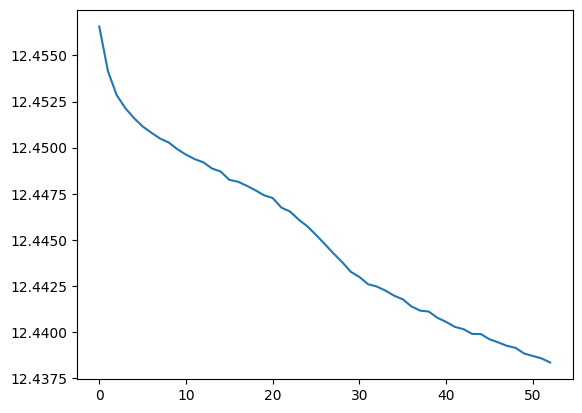

In [ ]:
plt.plot(mean_loss_traj_train)

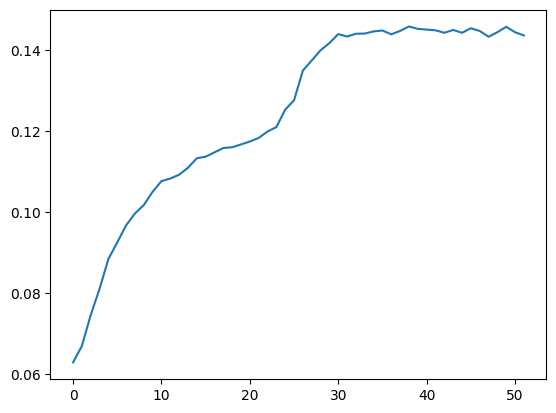

In [ ]:
plt.plot(mean_corr_traj_val)